# Introduction to nonlinear elasticity: deflection of a heavy hyperelastic beam 

In this notebook we give an example for the solution of a problem of nonlinear elasticity.

We focus on the simple problem of a cantilever beam loaded only by its own weigth

We exploit `UFL` features for automatic symbolic differentiation and formulate the problem by writing the potential energy of the system. 

We will use here the FEniCS  build-in nonlinear Netwon solver to solve the problem.

We strongly suggest to read also the fully commented`FEniCS` demo on hypelasticity 
https://fenicsproject.org/docs/dolfin/2019.1.0/python/demos/hyperelasticity/demo_hyperelasticity.py.html.

The comments in this noteboook are complentary to those provided  in the FEniCS demo

## Basic import statements and parameters

In [236]:
import dolfin
import mshr
import ufl
import numpy as np
import matplotlib.pyplot as plt
dolfin.parameters["form_compiler"]["cpp_optimize"] = True
dolfin.parameters["form_compiler"]["representation"] = "uflacs"
plt.style.use('seaborn-notebook')
%matplotlib inline

## Problem and solver setting

Create a mesh and the `ds` measures with boundary indicators 

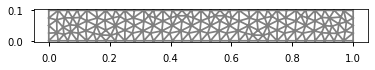

In [237]:
Lx, Ly = 1., .1
nx = 20
p0 = dolfin.Point(0,0)
p1 = dolfin.Point(Lx,Ly)
geom = mshr.Rectangle(p0,p1)
mesh = mshr.generate_mesh(geom,nx)

# Mark boundary subdomains
left = dolfin.CompiledSubDomain("near(x[0],0) && on_boundary")
right = dolfin.CompiledSubDomain("near(x[0],Lx) && on_boundary",Lx=Lx)
bottom = dolfin.CompiledSubDomain("near(x[1],0) && on_boundary")
top = dolfin.CompiledSubDomain("near(x[1],Ly) && on_boundary",Ly=Ly)

# Mark facets for Neumann BCs
boundary_indices = {'left': 1,
                    'right': 2,
                    'top': 3,
                    'bottom': 4}
boundary_markers = dolfin.MeshFunction("size_t", mesh, dim=1, value=0)
left.mark(boundary_markers, boundary_indices["left"])
right.mark(boundary_markers, boundary_indices["right"])
top.mark(boundary_markers, boundary_indices["top"])
bottom.mark(boundary_markers, boundary_indices["bottom"])

# Redefine element of area to include information about the markers
ds = dolfin.ds(domain=mesh, subdomain_data=boundary_markers)
dx = dolfin.dx(domain=mesh)
dolfin.plot(mesh)

We save the markers in an XDMF file that can be opened in paraview.

In [238]:
with dolfin.XDMFFile("mesh_functions.xdmf") as f:
    f.write(boundary_markers)

 We define now the finite element space for the displacement u

In [239]:
V_element = dolfin.VectorElement('CG', ufl.triangle, degree=2) 
V = dolfin.FunctionSpace(mesh, V_element)
u = dolfin.Function(V, name="u")
v = dolfin.TestFunction(V)
w = dolfin.TrialFunction(V)

 Let us introduce now some useful definition for the kinematics.
 These expresions are symbolic operators of UFL.
 At this level no computation is performed.

In [240]:
# Kinematics 
I = ufl.Identity(2)    # Identity tensor
F = ufl.variable(I + ufl.grad(u))  
C = F.T*F                   
Ic = ufl.tr(C)
J  = ufl.det(F)
E = 1/2*(C-I)
# Stored strain energy density (compressible neo-Hookean model)
# Elasticity parameters (plane-stress)
Y, nu = 1.e3, 0.3
mu, lmbda = dolfin.Constant(Y/(2*(1 + nu))), dolfin.Constant(Y*nu/((1 + nu)*(1 - 2*nu)))
lmbda = 2*lmbda*mu/(lmbda + 2*mu) 
psi = lmbda*ufl.tr(E)**2/2+mu*ufl.inner(E,E)

 We can have an automatic symbolic derivation of the strain energy density to define the First Piola-Kirchhoff stress 
 
 $${P}=\dfrac{\partial\Psi}{\partial F}$$
 
 To this end we use the `diff` operator of `UFL`(https://fenics.readthedocs.io/projects/ufl/en/latest/manual/form_language.html#variable-derivatives).
 
 Its use requires to define the symbol of the derivation variable as a `UFL` `variable`. 
 That is the reason why `F` in the preivous cell is defined as a `ufl.variable`.


In [241]:
P = ufl.diff(psi, F) 
n = dolfin.FacetNormal(mesh) # normal to the mesh

Hence, we can define the bulk force (`b0`) and surface traction (`g0`) and the total potential energy functional. in this example they are initially set to `0`.

In [242]:
b0 = dolfin.Constant(("0.0","0.0"))
Inertia = (1.*Ly**3)/12.
Lk = 2.*Lx
Fc= (np.pi*np.pi)*Y*Inertia/(Lk**2)
S=1.*Ly
sigc = Fc / S
print ('Charge critique de flambement:', sigc)
g0 = dolfin.Expression(("-t*sigc","eps*sigc"), eps=0.01, t=0, sigc=sigc, degree=0) 

# Total potential energy
potential_energy = psi*dx - ufl.dot(b0, u)*dx - ufl.dot(g0, u)*ds(boundary_indices['right'])

Charge critique de flambement: 2.0561675835602835


As a Dirichlet Boundary condition, we block the left-end

In [243]:
bcs = [dolfin.DirichletBC(V, (0.,0.), left)]

The variational problem to solve is the minimization of the potential energy with the given boundary conditions.

The problem is nonlinear and requires the use of a Newton solver. 

To this end we need to define the  *residual*, given by the first derivative of the energy, and the *Jacobian* (or *Hessian*), given by second directional derivative of the energy.

In FEniCS, thanks to the symbolic differentiation tools provided by `UFL` this can be done automatically, without effort from the user.

To this end we use the `derivative` function from `UFL` which allows us to calculate the directional derivative of a form.
We refer to the `UFL` manual for the syntax: https://fenics.readthedocs.io/projects/ufl/en/latest/manual/form_language.html#ad


In [244]:
# Compute first variation of the potential energy (directional derivative about u in the direction of v)
residual = ufl.derivative(potential_energy, u, dolfin.TestFunction(V))
# Compute Jacobian of the energy
jacobian = ufl.derivative(residual, u, dolfin.TrialFunction(V))

All the informations about the variational problem to be solved  (residual, jacobian, bcs, and indipendent variable) can be  collected in the dolfin class `NonlinearVariationalProblem` https://fenicsproject.org/docs/dolfin/2019.1.0/cpp/db/d3d/classdolfin_1_1NonlinearVariationalProblem.html

In [245]:
# Set the variational problem
problem = dolfin.NonlinearVariationalProblem(residual, u, bcs=bcs, J=jacobian)

We can define then a nonlinear solver class, provided by FEniCS.
This solver can implemented the basic newton method or more complex nonlinear solvers (that we will not discussed in class).
A long list of parameters can be specified. 
All the nonlinear solver available in `PETSc` can be used. We suggest the reading of the PETSC user manual (Chapter 5, SNES Solver). 

In [246]:
# dolfin.PETScOptions.set("help",1)
solver = dolfin.NonlinearVariationalSolver(problem)
dolfin.info(solver.parameters, True)
#solver.parameters.update({"nonlinear_solver":"snes"})
#dolfin.PETScOptions.set("snes_type","newtonls")


## Solve the static nonlinear problem

We can now solve the problem. 
To start let us initialize the solution at $u=(0,0)$ and set vanishing loads


Text(0.5, 1.0, 'Solution with vanishing force converged with 3 iterations and reason 1')

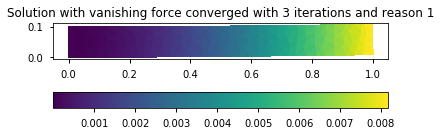

In [247]:
b0.t = 0.0
u.interpolate(dolfin.Constant((0.,0.)))
niterations, reason = solver.solve()
plt.colorbar(dolfin.plot(u, mode="displacement"), orientation="horizontal")
plt.title("Solution with vanishing force converged with {:d} iterations and reason {:b}".format(niterations,reason))

Without surprise the solution is null because the loading is null.
The solver gives the output the number of newton iterations required and the reason (`1`: converged, `0`: non-converged)

Let us increase sligtly the volume force. Always initializing at $u=(0,0)$. 

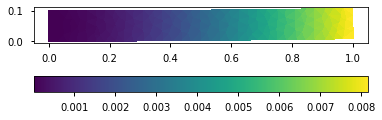

In [248]:
b0.t = 1.
u.interpolate(dolfin.Constant((0.,0.)))
solver.solve()
plt.colorbar(dolfin.plot(u, mode="displacement"), orientation="horizontal")

We get a reasonable solution, showing the deflection of the beam under its own weight. 
As a quantitative output we can get the average displacement at the rigth end.


Notes on the `python` synthax used below:
- For string formatting syntax see https://pyformat.info/
- list comprehension to generate a vector https://www.datacamp.com/community/tutorials/python-list-comprehension
- We use `*` to unpack a list https://docs.python.org/2/tutorial/controlflow.html#unpacking-argument-lists


In [249]:
uR = [dolfin.assemble(u[i]*ds(2))/Ly for i in [0, 1]]
print("The average displacement at the right end is u=({:.4f},{:.4f})".format(*uR))

The average displacement at the right end is u=(-0.0000,0.0083)


We can calculate the total reaction force at the left end to double-check against what we expect from global equilibrium:

In [250]:
fL = [dolfin.assemble((P*n)[i]*ds(1)) for i in [0, 1]]
fL_exact = [dolfin.assemble(b0[i]*dx) for i in [0, 1]]
print("The total reaction force at the left end is ({:.4f},{:.4f})".format(*fL))
print("The expected value is ({:+.4f},{:+.4f})".format(*fL_exact))

The total reaction force at the left end is (0.0018,-0.0019)
The expected value is (+0.0000,+0.0000)


The error is non-negligible. 
- Convergence toward the expected value can be oobtained after mesh refinement or increasing the interpolation order of the basis functions. 
- You can check also that the error will be very relevant with linear elements. The presence of body loading render linear element snon optimal. Have you an explication for this fact? 

## Solve of a quasi-static evolution problem with continuation

Consider now to increment slowly the loading with time. 
We discretise the time in $n_t$ time-steps of equal length 
At each time step $t_i$, the solution of the problem can be obtained by initializing the newton solver  with the solution of the previous time-step. This will greatly facilitate the convergence of the Newton algorithm. 

It sufficies to perform a `for` loop as follows. Note the initialization of the Newton algorithm at each time step is done with the latest solution available which is stored in memory

For visualisation, we store the solution in an `XDMF` file, that we can open with `paraview`.


*Remark:* 
- The initialization of the solution before starting the solver is fundamental in nonlinear problems, because the solution can be not unique. 

- Smaller time-steps generally helps convergence. Nonlinear solves can not converge for large time-step because the initialization of the newton solver is not close enough to a possible solution.

- Newton solvers converge very quickly (quadratic convergence rate) when they are close to a possible solution of the system to solve. But they can stagnate or diverge is they are not correctly initialized. 

- You can monitor the interation of the Newton solver in the terminal window where you launched `jupyter`.

You can play to test these points


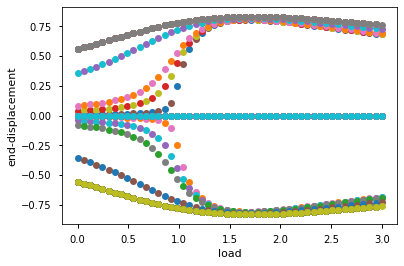

In [251]:
loads = np.linspace(0., 3., 50)
displ = np.zeros_like(loads)
u.interpolate(dolfin.Constant((0., 0.)))
file_u = dolfin.XDMFFile("output/u.xdmf")
file_u.parameters.update({"flush_output": True,
                          "functions_share_mesh": True,
                          "rewrite_function_mesh":False})
num = [0.01, 0.05, 0.1, 0.5, 1]
for (i, t) in enumerate(loads):
    for g0.eps in num:
        g0.t = t
        solver.solve()
        displ[i] = dolfin.assemble(u[1]*ds(2))/Ly 
        #dolfin.plot(u, mode = "displacement")
        #print("t={:+3.3f}, u={:+3.3f}".format(t, displ[i]))
        #plt.figure(1)
        with file_u as file:
            file.write(u,t)
        #plt.figure(2)
        plt.plot(loads,displ, "o",label='g0.eps = 0.01')
        plt.plot(loads,-displ,"o",label='g0.eps = -0.01')
        plt.plot(loads,-displ*0,"o",label='g0.eps = 0.')
        plt.xlabel("load")
        plt.ylabel("end-displacement")
        #leg = plt.legend();

In [253]:
loads = np.linspace(0, 3.5, 70)
displ1 = np.zeros_like(loads)
displ2 = np.zeros_like(loads)
displ3 = np.zeros_like(loads)
u.interpolate(dolfin.Constant((0., 0.)))
file_u = dolfin.XDMFFile("output/u.xdmf")
file_u.parameters.update({"flush_output": True,
                          "functions_share_mesh": True,
                          "rewrite_function_mesh":False})

from slepc_eigensolver import EigenSolver
from slepc4py import SLEPc

#Iperection dirige vers e haut
#Boucle 1 
for (i, t) in enumerate(loads):
    g0.t = t #Imperfection postive 
    g0.eps = 0.01
    solver.solve()
    aH = dolfin.inner(v,w)*dx 
    
    slepc_solver = SLEPc.EPS()
    slepc_solver.create()
    slepc_solver.setWhichEigenpairs(slepc_solver.Which.TARGET_MAGNITUDE)
    slepc_solver.setFromOptions()
    slepc_solver.setTarget(0.0) 
    st =slepc_solver.getST()
    st.setType('sinvert')
    
    eig_solver = EigenSolver(ddE, aH, u, bcs=bcs, slepc_eigensolver=slepc_solver)
    ncv, it = eig_solver.solve(10)
    eigenvalues, [eigenvectors_real, eigenvectors_im] = eig_solver.get_eigenpairs(10)
    eig_solver.save_eigenvectors(ncv)
    
    if (min(eigenvalues) > 0.):
        displ1[i] = dolfin.assemble(u[1]*ds(2))/Ly
        plt.plot(loads[i], displ1[i], "*g")
        
    else:
        displ1[i] = dolfin.assemble(u[1]*ds(2))/Ly
        plt.plot(loads[i], displ1[i], "*r")

u.interpolate(dolfin.Constant((0., 0.)))

#Boucle 2


for (i, t) in enumerate(loads):
    g0.t = t #Imperfection postive 
    g0.eps = -0.01
    solver.solve()
    aH = dolfin.inner(v,w)*dx 
    
    slepc_solver = SLEPc.EPS()
    slepc_solver.create()
    slepc_solver.setWhichEigenpairs(slepc_solver.Which.TARGET_MAGNITUDE)
    slepc_solver.setFromOptions()
    slepc_solver.setTarget(0.0) 
    st =slepc_solver.getST()
    st.setType('sinvert')
    
    eig_solver = EigenSolver(ddE, aH, u, bcs=bcs, slepc_eigensolver=slepc_solver)
    ncv, it = eig_solver.solve(10)
    eigenvalues, [eigenvectors_real, eigenvectors_im] = eig_solver.get_eigenpairs(10)
    eig_solver.save_eigenvectors(ncv)
    
    if (min(eigenvalues) > 0.):
        displ2[i] = dolfin.assemble(u[1]*ds(2))/Ly
        plt.plot(loads[i], displ2[i], "*g")
        
    else:
        displ2[i] = dolfin.assemble(u[1]*ds(2))/Ly
        plt.plot(loads[i], displ2[i], "*r")
        
        
for (i, t) in enumerate(loads):
    g0.t = t #Imperfection postive 
    g0.eps = 0.
    solver.solve()
    aH = dolfin.inner(v,w)*dx 
    
    from slepc_eigensolver import EigenSolver
    from slepc4py import SLEPc   
    slepc_solver = SLEPc.EPS()
    slepc_solver.create()
    slepc_solver.setWhichEigenpairs(slepc_solver.Which.TARGET_MAGNITUDE)
    slepc_solver.setFromOptions()
    slepc_solver.setTarget(0.0) 
    st =slepc_solver.getST()
    st.setType('sinvert')
    
    eig_solver = EigenSolver(ddE, aH, u, bcs=bcs, slepc_eigensolver=slepc_solver)
    ncv, it = eig_solver.solve(10)
    eigenvalues, [eigenvectors_real, eigenvectors_im] = eig_solver.get_eigenpairs(10)
    eig_solver.save_eigenvectors(ncv)
    
    if (min(eigenvalues) > 0.):
        displ3[i] = dolfin.assemble(u[1]*ds(2))/Ly
        plt.plot(loads[i], displ3[i], "*g")
        
    else:
        displ3[i] = dolfin.assemble(u[1]*ds(2))/Ly
        plt.plot(loads[i], displ3[i], "*r")


NameError: name 'ddE' is not defined

# Wrap up

Let us refactor the nonlinear solver in a function that resume the code required to solve the problem.

In [ ]:
import dolfin
import ufl
import numpy as np
import matplotlib.pyplot as plt
dolfin.parameters["form_compiler"]["cpp_optimize"] = True
dolfin.parameters["form_compiler"]["representation"] = "uflacs"
plt.style.use('seaborn-notebook')

def solve_hyperelasticity(load_max=0.1, nsteps=40, load_min=0, nu=0.3, nx=20, ny=5, Lx=1, Ly=.1):
    dim = 2
    degree = 2
    mesh = dolfin.RectangleMesh(dolfin.Point(0, 0), dolfin.Point(Lx, Ly), nx, ny)
    left = dolfin.CompiledSubDomain("near(x[0], 0) && on_boundary")
    right = dolfin.CompiledSubDomain("near(x[0], Lx) && on_boundary", Lx=Lx)
    boundary_markers = dolfin.MeshFunction("size_t", mesh, dim=1, value=0)
    left_index = 1
    right_index = 2
    left.mark(boundary_markers, left_index)
    right.mark(boundary_markers, right_index)
    ds = dolfin.ds(domain=mesh,subdomain_data=boundary_markers)
    dx = dolfin.dx(domain=mesh)
    
    V_element = dolfin.VectorElement('CG', ufl.triangle, degree=degree, dim=dim) 
    V = dolfin.FunctionSpace(mesh, V_element)
    u = dolfin.Function(V, name="u")
    v = dolfin.TestFunction(V)
    w = dolfin.TrialFunction(V)
    
    I = ufl.Identity(dim)
    F = ufl.variable(I + ufl.grad(u))  
    C = F.T*F                   
    Ic = ufl.tr(C)
    J  = ufl.det(F)
    E = 1/2*(C-I)
    Y = 1.e3
    mu, lmbda = dolfin.Constant(Y/(2*(1 + nu))), dolfin.Constant(Y*nu/((1 + nu)*(1 - 2*nu)))
    lmbda = 2*lmbda*mu/(lmbda + 2*mu) 
    psi = (mu/2)*(Ic - 2) - mu*ufl.ln(J) + (lmbda/2)*(ufl.ln(J))**2
    
    b0 = dolfin.Expression(("0.0", "t*mu"), t=0, mu=mu, degree=0)  
    g0 = mu*dolfin.Constant((0.0,0.0)) 
    
    potential_energy = psi*dx - ufl.dot(b0, u)*dx - ufl.dot(g0, u)*ds(2)
    residual = ufl.derivative(potential_energy, u, v)
    jacobian = ufl.derivative(residual, u, w)
    bcs = [dolfin.DirichletBC(V, (0., 0.), left)]
    problem = dolfin.NonlinearVariationalProblem(residual, u, bcs=bcs, J=jacobian)
    solver = dolfin.NonlinearVariationalSolver(problem)
    loads = np.linspace(load_min, load_max, nsteps)
    displ = np.zeros_like(loads)
    u.interpolate(dolfin.Constant((0.,0.)))
    file_u = dolfin.XDMFFile("output/u.xdmf")
    file_u.parameters.update({"flush_output": True,
                              "functions_share_mesh": True,
                              "rewrite_function_mesh": False})
    for (i, t) in enumerate(loads):
        b0.t = -t
        solver.solve()
        displ[i] = dolfin.assemble(u[1]*ds(2))/Ly 
        print("t={:+3.3f}, u={:+3.3f}".format(t, displ[i]))
        with file_u as file:
            file.write(u, t)
    plt.figure(2)
    plt.plot(loads,displ,"o")
    plt.xlabel("load")
    plt.ylabel("end-displacement")
    plt.savefig("output/displacement.png")
    return (loads,displ)

In [ ]:
#def sigma(eps):
#    return lmbda*ufl.tr(eps)*I+2*mu*eps

#a_K_0 = dolfin.inner(sigma(dolfin.sym(dolfin.grad(u))),dolfin.sym(dolfin.grad(v)))*dx
#a_g_0 = dolfin.inner(du.dx(0), v.dx(0))*dx

#eig_solver = EigenSolver(a_k,a_g)
#neig = 3
#ncv, it = eig_solver.solve(10)

#eigenvalues, [eigenvectors_real, eigenvectors_im]= eig_solver, get_eigenpairs(10)

We can then test it:

In [ ]:
loads, displ = solve_hyperelasticity(load_max=.3,nsteps=40,load_min=0,nu=0.3,nx=20,ny=5,Lx=1,Ly=.1)

# Exercice
- Try to increase the maximum loading to 0.3. Is the Newton solver converging?
- Try to replace the elastic energy density with the weakly incompressible Neo-Hookean mode where:
$$
\psi(F) = \dfrac{\mu}{2}(\mathrm{tr}(F^T F) - 2) - \mu\ln(\det F) + (\lambda/2)*(\ln(\det F))^2
$$
and perform again the numerical simulation for a loading going form 0 to 0.3. Is now the Newton solver converging? 
- A further *optional* analytical exercice: calculate by analytical derivation for the energy density given above.
    $$P=\dfrac{\partial \psi(F)}{\partial F}$$
    You can find help in a book of nonlinear elasticity. For example, see Sec. 3.5 of *P.Wriggers, Nonlinear Finite Element Methods, Springer*, that you can download legally from your digital library on the monUPMC account.